# Detection of character

In [4]:

import inspect

import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images


Using cache found in C:\Users\ty/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-9-20 Python-3.10.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16384MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 408x612 4 persons
Speed: 10.0ms pre-process, 32.0ms inference, 6.1ms NMS per image at shape (1, 3, 448, 640)
Saved 1 image to runs\detect\exp3


,xmin,ymin,xmax,ymax,confidence,class,name
0,68.956627,56.606556,172.233780,377.539978,0.947774,0,person
1,177.375092,48.463020,287.581024,372.577240,0.939201,0,person
2,290.673645,52.862259,397.646057,376.271484,0.930030,0,person
3,405.168213,78.669266,508.620392,381.421539,0.926071,0,person


In [7]:
imgs = [r"C:\Users\ty\Downloads\4-people.jpg"]  # batch of images
model.to('cuda')
# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

image 1/1: 408x612 4 persons
Speed: 9.0ms pre-process, 33.3ms inference, 3.0ms NMS per image at shape (1, 3, 448, 640)
Saved 1 image to runs\detect\exp6


,xmin,ymin,xmax,ymax,confidence,class,name
0,68.956627,56.606556,172.233780,377.539978,0.947774,0,person
1,177.375092,48.463020,287.581024,372.577240,0.939201,0,person
2,290.673645,52.862259,397.646057,376.271484,0.930030,0,person
3,405.168213,78.669266,508.620392,381.421539,0.926071,0,person


'AutoShape'

# Openpose for pose generation

In [30]:
from PIL import Image
from controlnet_aux import OpenposeDetector
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load image
img = Image.open(imgs[0]).convert("RGB")



# load checkpoints
open_pose = OpenposeDetector.from_pretrained("lllyasviel/Annotators")
open_pose.to(device)



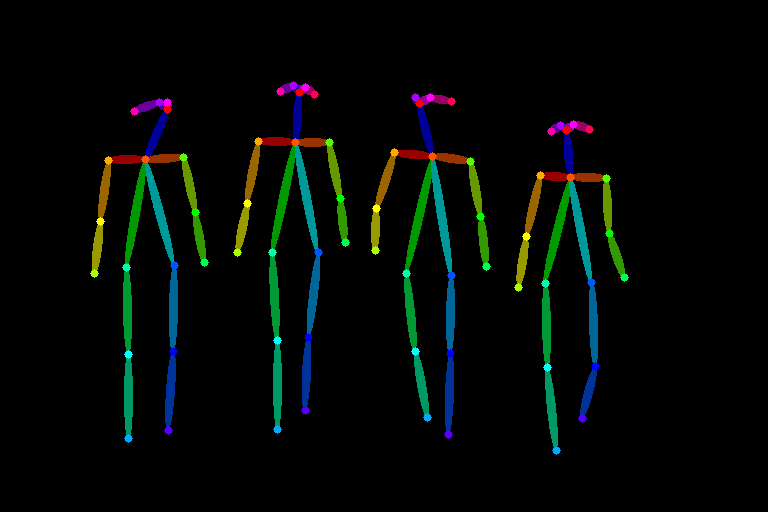

In [17]:

# process
processed_image_open_pose = open_pose(img)

processed_image_open_pose

pose images size

In [24]:
processed_image_open_pose.size

(768, 512)

bbox detection image sizes

In [31]:
img.size

(612, 408)

# Draw prediction bboxes on top the pose

the pose image is of w, h = 768 x 512

BBOXES need to be scaled according to this

In [32]:
def scale_bbox(bbox, original_dims, new_dims):
    """
    Scale bounding box according to new dimensions.

    Parameters:
    - bbox: List of [xmin, ymin, xmax, ymax]
    - original_dims: Tuple of (original_width, original_height)
    - new_dims: Tuple of (new_width, new_height)

    Returns:
    - Scaled bounding box as [xmin', ymin', xmax', ymax']
    """
    w_ratio = new_dims[0] / original_dims[0]
    h_ratio = new_dims[1] / original_dims[1]

    return [
        bbox[0] * w_ratio,  # xmin'
        bbox[1] * h_ratio,  # ymin'
        bbox[2] * w_ratio,  # xmax'
        bbox[3] * h_ratio   # ymax'
    ]

# Example usage:
bbox = [100, 50, 500, 350]
original_dims = (612, 408)
new_dims = (768, 512)

scaled_bbox = scale_bbox(bbox, original_dims, new_dims)
print(scaled_bbox)


[125.49019607843137, 62.745098039215684, 627.4509803921569, 439.2156862745098]


In [36]:
df = results.pandas().xyxy[0]

In [37]:
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,68.956627,56.606556,172.233780,377.539978,0.947774,0,person
1,177.375092,48.463020,287.581024,372.577240,0.939201,0,person
2,290.673645,52.862259,397.646057,376.271484,0.930030,0,person
3,405.168213,78.669266,508.620392,381.421539,0.926071,0,person


In [40]:
df['bbox_new'] = df.apply(lambda row: scale_bbox([row['xmin'], row['ymin'], row['xmax'], row['ymax']], (img.size[0], img.size[1]), (processed_image_open_pose.size[0], processed_image_open_pose.size[1])), axis=1)






In [41]:
df

,xmin,ymin,xmax,ymax,confidence,class,name,bbox_new
0,68.956627,56.606556,172.233780,377.539978,0.947774,0,person,"[86.53380629595588, 71.03567804074754, 216.136..."
1,177.375092,48.463020,287.581024,372.577240,0.939201,0,person,"[222.58835018382354, 60.8163392310049, 360.885..."
2,290.673645,52.862259,397.646057,376.271484,0.930030,0,person,"[364.7669270833333, 66.33695235906863, 499.006..."
3,405.168213,78.669266,508.620392,381.421539,0.926071,0,person,"[508.44638480392155, 98.72221583946079, 638.26..."


In [45]:
bbox1 = df.iloc[0]['bbox_new']
print(bbox1)

[86.53380629595588, 71.03567804074754, 216.13650811887254, 473.7756587009804]


In [48]:
import cv2
import numpy as np 
processed_array = np.array(processed_image_open_pose)

for k in range(df.shape[0]):
    bbox1 = df.iloc[k]['bbox_new']
    # plot the bbox1 [xmin, ymin, xmax, ymax]
    rectangled = cv2.rectangle(processed_array, (int(bbox1[0]), int(bbox1[1])), (int(bbox1[2]), int(bbox1[3])), (0, 255, 0), 2)


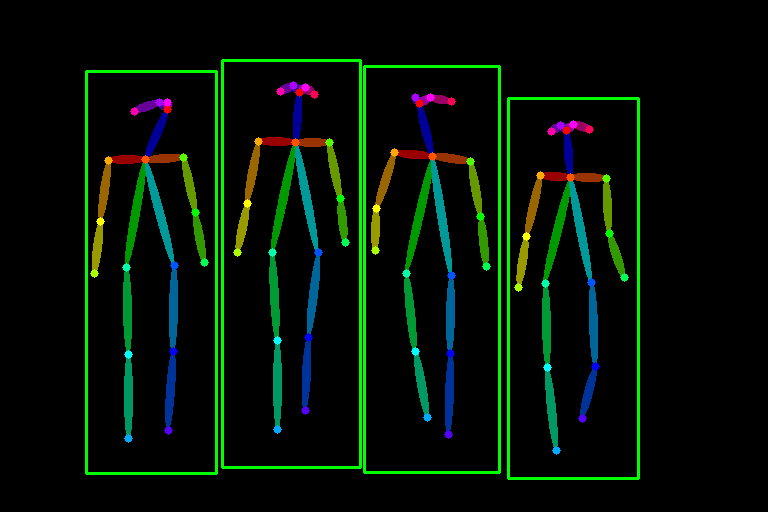

In [49]:
from PIL import Image
Image.fromarray(rectangled)

# Face inpainter